In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import datetime
import lzma
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
import numpy as np
import nustar_pysolar as nustar
import pickle
import sunpy.map

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from sunpy_movies import maker

# *NuSTAR* example

## Define some functions

In [15]:
def make_det_array(evt_data: fits.FITS_rec) -> np.ndarray:
    """
    Makes an array tracking the most recent det
    that apppears in each pixel.
    """

    arr = np.full((2999,2999), -1)

    x, y = evt_data['X'], evt_data['Y']
    dets = evt_data['DET_ID']
    arr[y,x] = dets

    return arr


def make_det_map(evt_data: fits.FITS_rec, hdr: fits.Header) -> sunpy.map.Map:
    """
    Makes a map consisting of the det information for each pixel.
    Note that if photons from different detectors hit the same pixel,
    the most recent value is what will be contained within the pixel.
    """

    # Replace the map data with the DET data.
    det_map = nustar.map.make_sunpy(evt_data, hdr)
    det_map.data[:] = make_det_array(evt_data)

    return det_map


def make_submap(
    map_: sunpy.map.Map,
    bottom_left: tuple[u.Quantity, u.Quantity],
    top_right: tuple[u.Quantity, u.Quantity]
) -> sunpy.map.Map:
    """
    Create a submap of the provided map object and corners.
    """
    
    bl = SkyCoord(*bottom_left, frame=map_.coordinate_frame)
    tr = SkyCoord(*top_right, frame=map_.coordinate_frame)

    return map_.submap(bottom_left=bl, top_right=tr)


def convert_nustar_time_to_astropy_time(time: float) -> Time:

    str_fmt = '%Y-%m-%d %H:%M:%S'
    rel_t = datetime.datetime.strptime('2010-01-01 00:00:00', str_fmt).replace(tzinfo=datetime.timezone.utc)
    dt_time = rel_t + datetime.timedelta(seconds=time)
    s = dt_time.strftime(str_fmt)

    return Time(s, format='iso', scale='utc')


def make_movie_maps(
    evt_data: fits.FITS_rec,
    hdr: fits.Header,
    time_ranges: list[tuple]
) -> tuple[list[sunpy.map.Map]]:
    
    maps_ = []
    det_maps = []
    bottom_left = (-500, -300) * u.arcsec
    top_right = (500, 700) * u.arcsec
    vmin, vmax = 1e6, -1
    for trange in time_ranges:
        inds = nustar.filter.by_time(evt_data, hdr, trange)
        filt_evt = evt_data[inds]
        map_ = nustar.map.make_sunpy(filt_evt, hdr)
        map_ = make_submap(map_, bottom_left, top_right)
        det_map = make_submap(make_det_map(filt_evt, hdr), bottom_left, top_right)
        map_.plot_settings['cmap'] = plt.get_cmap('Spectral_r')
        map_.plot_settings['title'] = f'{trange[0]} - {trange[1]}'

        det_map.plot_settings['title'] = map_.plot_settings['title']
        det_map.plot_settings['cmap'] = plt.get_cmap('jet')
        
        mmin, mmax = np.nanmin(map_.data), np.nanmax(map_.data)
        if mmin < vmin:
            vmin = mmin
        if mmax > vmax:
            vmax = mmax
        
        maps_.append(map_)
        det_maps.append(det_map)

    for map_ in maps_:
        map_.plot_settings['norm'] = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    
    return maps_, det_maps

# Process the data

In [17]:
with lzma.open('nustar_data.pkl', 'rb') as infile:
    evt_data, hdr = pickle.load(infile)

start = convert_nustar_time_to_astropy_time(evt_data['TIME'][0])
end = convert_nustar_time_to_astropy_time(evt_data['TIME'][-1])

slices = maker.make_time_slices(start, end, 60*u.s, 60*u.s)
maps_, det_maps = make_movie_maps(evt_data, hdr, slices)

# Make the movie

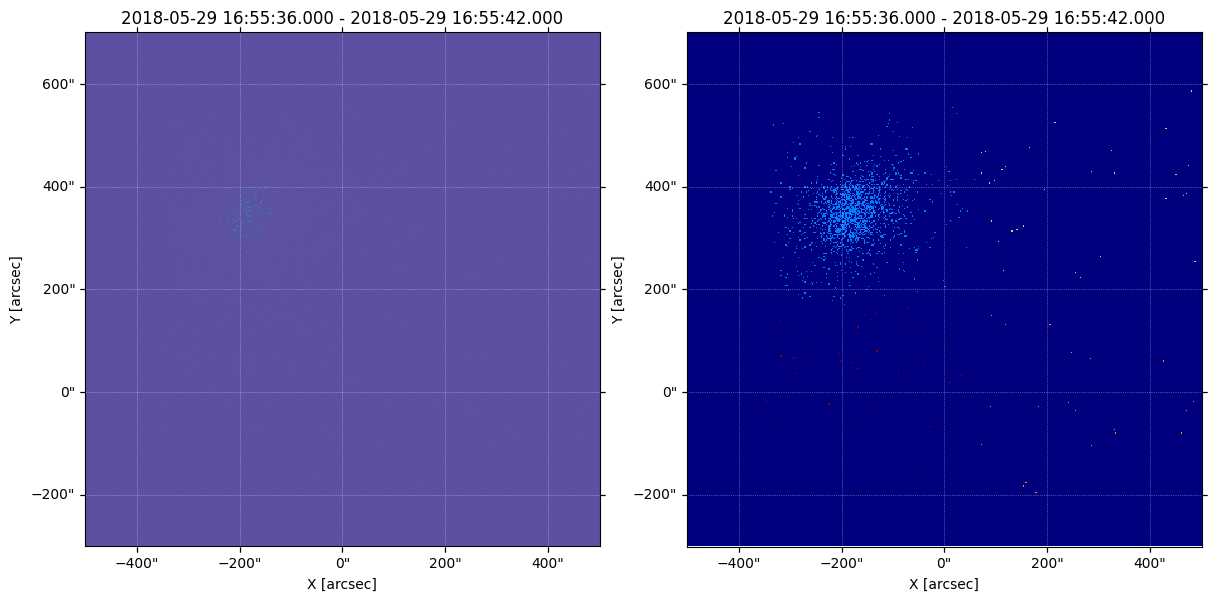

In [18]:
def init_func(fig: plt.Figure, ax: plt.Axes, map_: sunpy.map.Map) -> None:
    ax.set_xlabel('X [arcsec]')
    ax.set_ylabel('Y [arcsec]')


def plot_func(fig: plt.Figure, ax: plt.Axes, map_: sunpy.map.Map) -> None:
    ax.set_title(map_.plot_settings['title'])


exposure_set = maker.MapSet(
    maps_,
    init_func=init_func,
    plot_func=plot_func,
    ax=None
)
det_set = maker.MapSet(
    det_maps,
    init_func=init_func,
    plot_func=plot_func,
    ax=None
)

fig = plt.figure(figsize=(12,6.1), layout='constrained')
movie_maker = maker.SunpyMovieMaker([exposure_set, det_set], fig=fig)
movie_maker.make_movie(out_path='./nustar.gif')